## Import thư viện

In [1]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19

## Show kết quả quá trình training

In [2]:
def plot_hist(path):
  history = pd.read_csv(path)

  acc = history['accuracy']
  val_acc = history['val_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('epoch')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Crossentropy')
  plt.ylim([min(plt.ylim()), max(plt.ylim())])
  plt.title('Training and Validation Loss')

  plt.xlabel('epoch')
  plt.savefig('evaluation.jpg')
  plt.show()

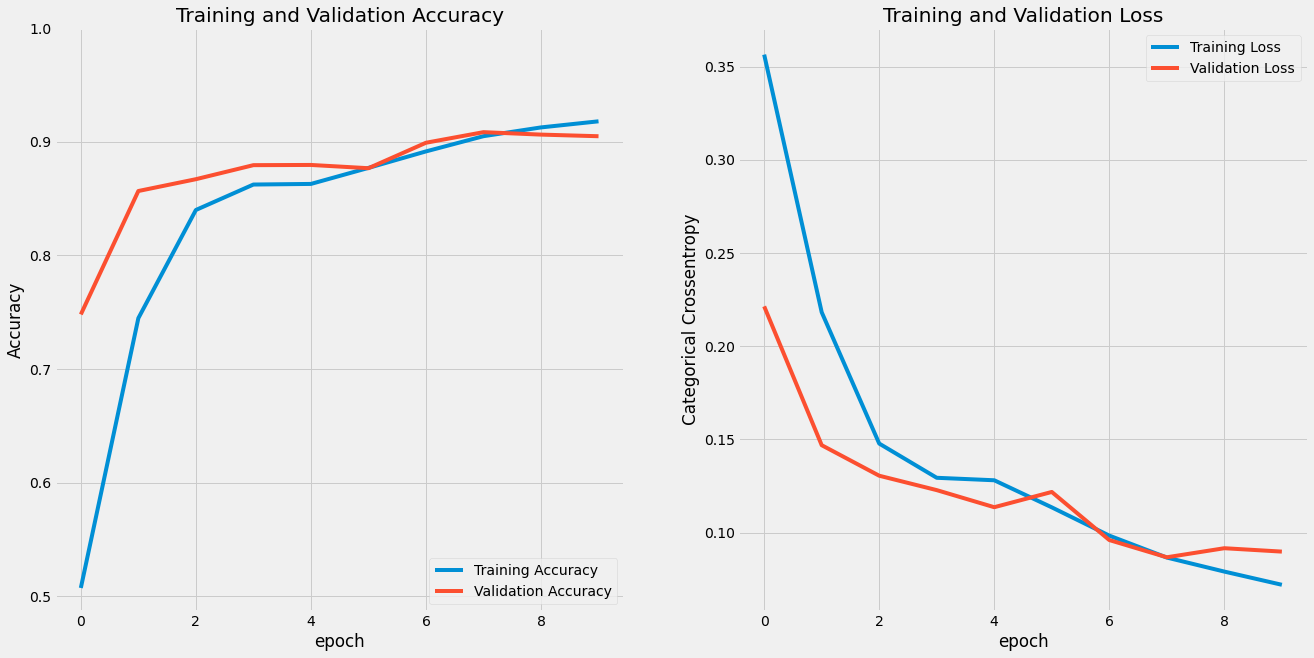

In [3]:
plot_hist("../input/fgvc8vgg19/FGVC8-VGG19.log")

## Load model

In [4]:
HEIGHT = 480
WIDTH = 480
CHANNELS = 3
CLASSES = 6
top_dropout_rate = 0.2
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
weights_path = "../input/fgvc8vgg19/FGVC8-VGG19t.h5"

In [6]:
def get_model():
    VGG19_MODEL = tf.keras.applications.VGG19(weights=None ,include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    
    x=VGG19_MODEL.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(256,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(128,activation='relu')(x)
    prediction=Dense(6,activation='sigmoid')(x)

    model=Model(inputs=VGG19_MODEL.input, outputs=prediction)
    
    return model

In [7]:
model = get_model()
model.load_weights(weights_path)

2021-11-29 06:04:48.496355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 06:04:48.597876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 06:04:48.598624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 06:04:48.599779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Load data test

In [8]:
test_img = '../input/plant-pathology-2021-fgvc8/test_images'
submission = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


## Preprocessing test data

In [9]:
def load_image(image_id):
    file_path = str(image_id)
    img = cv2.imread(test_img+'/'+file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [10]:
def data_full_augment(image):
    
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    flag = False

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        flag = True
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        flag = True
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        flag = True


    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        flag = True
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
        flag = True
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
        flag = True
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90
        flag = True
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
        flag = True
    elif p_crop > .4:
        HEIGHT1 = image.shape[0]
        WIDTH1 = image.shape[1]
        crop_size_h = tf.random.uniform([], int(HEIGHT1*.8), HEIGHT1, dtype=tf.float32)
        crop_size_w = tf.random.uniform([], int(WIDTH1*.8), WIDTH1, dtype=tf.float32)
        image = tf.image.random_crop(image, size=[crop_size_h, crop_size_w, 3])
        flag = True
    
    return image

In [11]:
def process(path):
    img = load_image(path)
    img = data_full_augment(img)
    img = tf.cast(img, tf.float32) / 255.0
    img = np.array(img)
    return cv2.resize(img , (480, 480)).reshape(-1, 480, 480, 3)

## Predict

In [12]:
preds = []
for i in range(len(submission['image'])):
    test_images = submission['image'][i]
    pred = model.predict(process(test_images))[0]
    preds.append(pred)
    
preds = np.array(preds)

2021-11-29 06:04:54.046342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-29 06:04:54.966843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [13]:
perdict = (preds>0.27)
n_label = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']
answer = []

for i in range(perdict.shape[0]):
    temp = []
    for j, k in enumerate(n_label):
        if perdict[i, j]:
            temp.append(k)
    if len(temp) > 1 and "healthy" in temp:
        temp.remove("healthy")
    elif len(temp) == 0:
        temp.append('healthy')
    answer.append(temp)
    
answer = [' '.join(n) for n in answer]

In [14]:
submission['labels'] = np.array(answer)
submission

,image,labels
0,85f8cb619c66b863.jpg,scab
1,ad8770db05586b59.jpg,complex frog_eye_leaf_spot scab
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot


## Submission

In [15]:
submission.to_csv('submission.csv', index=False)